In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics
import tqdm
import matplotlib.gridspec as gridspec
import graphviz

from dask import delayed
from joblib import parallel_backend
from dask.distributed import Client, progress
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
#from yellowbrick.model_selection import FeatureImportances

#from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.utils import class_weight
# from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
# client = Client(processes=False, threads_per_worker=64,
#                 n_workers=10, memory_limit='2000GB')
# client

In [3]:
%%javascript

Jupyter.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-shift-d', {
    help : 'Duplicate current line',
    help_index : 'zz',
    handler: function(env) {
        var cm=env.notebook.get_selected_cell().code_mirror;
        // get a position of a current cursor in a current cell
        var current_cursor = cm.doc.getCursor();

        // read a content from a line where is the current cursor
        var line_content = cm.doc.getLine(current_cursor.line);
        cm.execCommand('goLineEnd');
        cm.execCommand('newlineAndIndent');
        cm.execCommand('indentLess');
        cm.doc.replaceSelection(line_content);
        cm.doc.setCursor(current_cursor.line + 1, current_cursor.ch);
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [5]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

tw = selected_columns.sample(50000)
ttw = selected_columns.sample(1000)
tttw = selected_columns.sample(50)

X, Xs, y, ys = selected_columns.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), tw.drop(columns=['>50K', 'YRMARR', 'PWTYPE', 'BPLD', 'DEGFIELDD', 'EDUCD', 'PWMET13', 'BIRTHYR', 'SLWT', 'BPLD', 'RELATED', 'ANCESTR1D', 'EMPSTATD', 'PWMET13ERR', 'COUNTYICP']), selected_columns.filter(['>50K']), tw.filter(['>50K'])
Z, Zs = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), tw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']) 
Zss, yss = ttw.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), ttw.filter(['>50K'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.2, random_state=42)
Z_train, Z_test, q_train, q_test = train_test_split(Z, y, test_size=0.2, random_state=42)
Zs_train, Zs_test, qs_train, qs_test = train_test_split(Zs, ys, test_size=0.2, random_state=42)
Zss_train, Zss_test, qss_train, qss_test = train_test_split(Zss, yss, test_size=0.2, random_state=42)


train_df = Zs_train.copy()
train_df['$$$'] = ys_train

std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
Xs_train_scaled = std.fit_transform(Xs_train)
Z_train_scaled = std.fit_transform(Z_train)
Zs_train_scaled = std.fit_transform(Zs_train)
Zss_train_scaled = std.fit_transform(Zss_train)

Too slow below

In [ ]:
# from imblearn.under_sampling import CondensedNearestNeighbour

# cnn = CondensedNearestNeighbour()

# with parallel_backend('threading', n_jobs=-1):
#     # X_resampled, y_resampled = cnn.fit_resample(X, y)
# #     Xs_resampled, ys_resampled = cnn.fit_resample(Xs[:100], ys[:100])
#     Z_train_resampled, q_train_resampled = cnn.fit_resample(Z_train, q_train)
# #     Zs_resampled, ys_resampled = cnn.fit_resample(Zs, ys)
# #     Zss_train_resampled, qss_train_resampled = cnn.fit_resample(Zss_train, qss_train)



In [6]:
from imblearn.under_sampling import NearMiss

nm1 = NearMiss(version=1)

with parallel_backend('threading', n_jobs=-1):
    # X_resampled, y_resampled = cnn.fit_resample(X, y)
#     Xs_resampled, ys_resampled = cnn.fit_resample(Xs[:100], ys[:100])
    Z_train_resampled, y_train_resampled = nm1.fit_resample(Z_train, q_train)
#     Zs_resampled, ys_resampled = cnn.fit_resample(Zs, ys)
#     Zss_train_resampled, qss_train_resampled = cnn.fit_resample(Zss_train, qss_train)

In [8]:
Z_train_resampled.describe()

,EDUC,UHRSWORK,OCC,VALUEH,DEGFIELD,AGE,SEX,TRANWORK
count,940078.000000,940078.000000,940078.000000,9.400780e+05,940078.000000,940078.000000,940078.000000,940078.000000
mean,7.797071,25.889539,2336.903252,3.527803e+05,16.663639,57.042832,1.484373,8.329497
std,2.423795,22.313710,2829.301360,4.508474e+05,23.631330,16.205763,0.499756,13.153206
min,0.000000,0.000000,0.000000,1.000000e+03,0.000000,16.000000,1.000000,0.000000
25%,6.000000,0.000000,0.000000,1.460000e+05,0.000000,45.000000,1.000000,0.000000
50%,7.000000,40.000000,800.000000,2.500000e+05,0.000000,58.000000,1.000000,10.000000
75%,10.000000,40.000000,4700.000000,4.000000e+05,33.000000,69.000000,2.000000,10.000000
max,11.000000,99.000000,9920.000000,6.288000e+06,64.000000,96.000000,2.000000,70.000000


In [9]:
y_train_resampled.describe()

,>50K
count,940078.0
mean,0.5
std,0.5
min,0.0
25%,0.0
50%,0.5
75%,1.0
max,1.0


In [21]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
nm1.fit(Z_train, y_train, class_weight=class_weights)

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[0. 1.], y=         >50K
1971391   0.0
2804169   1.0
62430     1.0
1226121   0.0
2131220   0.0
...       ...
503575    1.0
2496478   0.0
256691    1.0
1212783   1.0
237211    1.0

[1462455 rows x 1 columns] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


ValueError: classes should include all valid labels that can be in y

In [ ]:

sns.countplot(y_train['>50K'])


In [ ]:
sns.countplot(y_train_resampled['>50K'])

### Random Forest Classifier

In [ ]:
min_samples_split = [2,4,6,10,20]

for splits in min_samples_split:
    rf = RandomForestClassifier(min_samples_split=splits)
    rf.fit(Z_train_resampled, y_train_resampled)
    print('----------------------------------')
    print(f"Min samples split = {splits}")
    print(f'r2 train= {rf.score(Zs_train, ys_train)}')
    print(f'r2 test= {rf.score(Zs_test, ys_test)}')
    print('----------------------------------')
    rf.fit(Zs_train, ys_train)
    print('----------------------------------')
    print(f"Min samples split = {splits}")
    print(f'r2 train scaled= {rf.score(Zs_train, ys_train)}')
    print(f'r2 test= {rf.score(Zs_test, ys_test)}')
    print('----------------------------------')

### Random Forest Regressor


### Extra Trees Regressor?

In [ ]:
train_df['$$$'].sum()

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, DecisionTreeRegressor
features = list(Z.columns)
features

['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'TRANWORK']

In [24]:
dt = DecisionTreeClassifier(min_samples_split=2, random_state=69)
dt.fit(Zs_train, ys_train)

DecisionTreeClassifier(random_state=69)

In [30]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

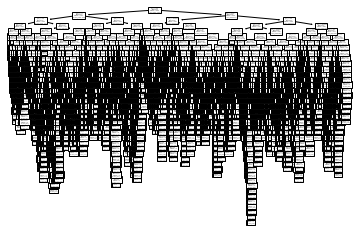

In [25]:
from joblib import parallel_backend

with parallel_backend('threading', n_jobs=-1):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(Zs_train, ys_train)
    tree.plot_tree(clf)

    dot_data = tree.export_graphviz(clf, feature_names=features,
                        filled=True, rounded=True,  
                       special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph 

/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/nick/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


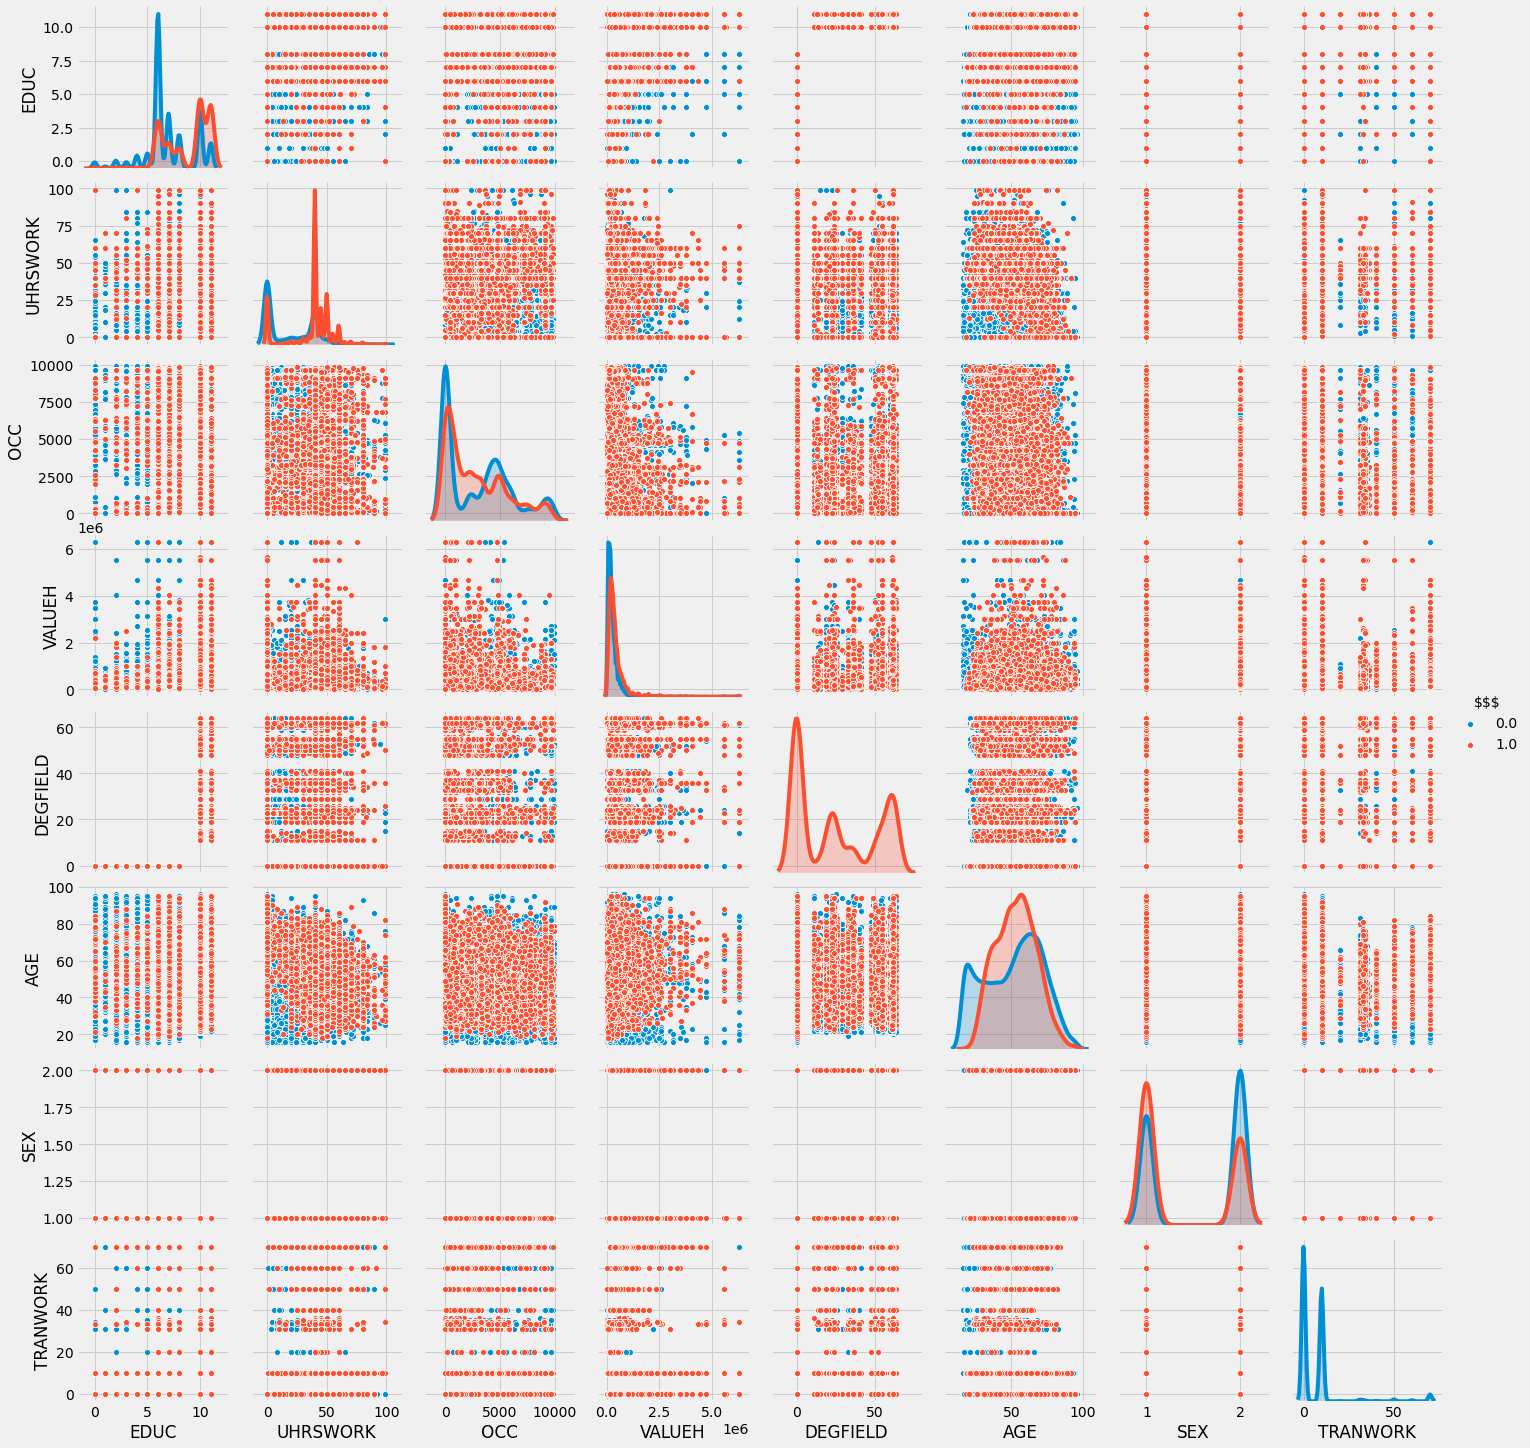

In [33]:
sns.pairplot(train_df, hue='$$$')

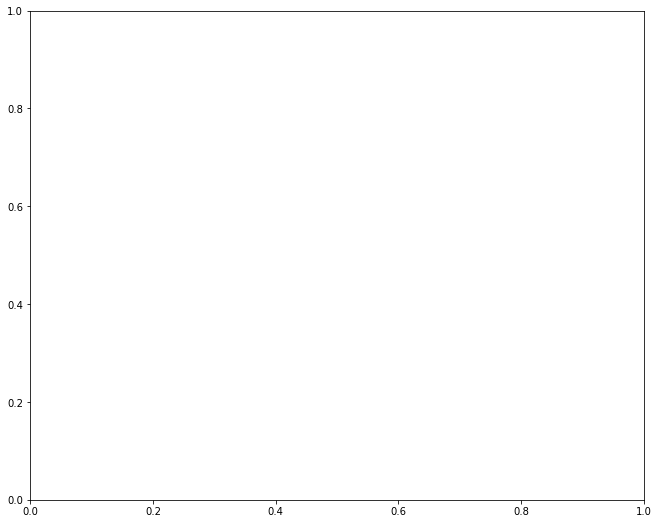

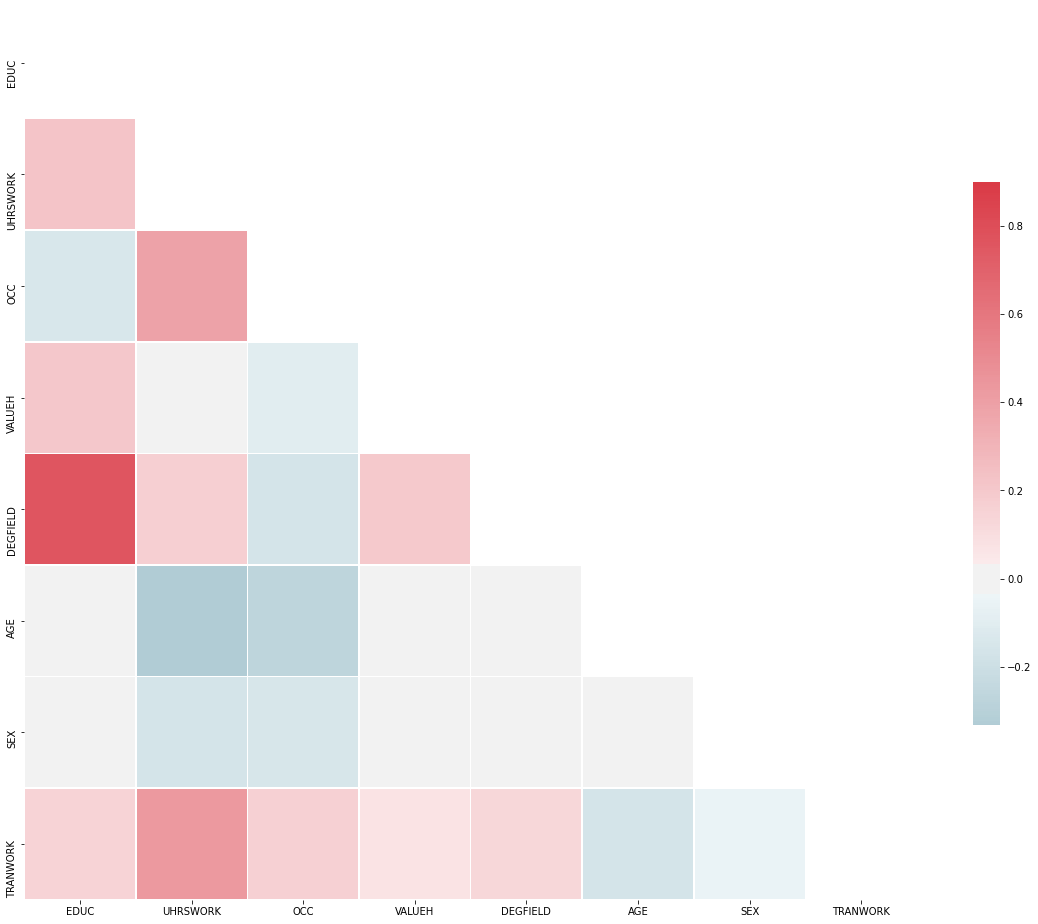

In [27]:
corr = Zs.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)


plt.figure(figsize=[20, 20])
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [45]:
regr = RandomForestRegressor(max_depth=30, random_state=42)
regr.fit(Xs_train, ys_train)
print(regr.score(Xs_train, ys_train))
print(regr.score(Xs_test, ys_test))

regr.fit(Zs_train, qs_train)
print(regr.score(Zs_train, qs_train))
print(regr.score(Zs_test, qs_test))




<ipython-input-45-c740ec6bb47e>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(Xs_train, ys_train)


0.9204215506718003
0.4560931700760974


<ipython-input-45-c740ec6bb47e>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(Zs_train, qs_train)


0.9015058048398435
0.38045424110283743
